In [18]:
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from pathlib import Path

In [8]:
# Setup
data_root = Path("../data")
cities = sorted([d for d in data_root.iterdir() if d.is_dir()])

def explore_data_structure(data_root):
    """Understand the data organization"""
    print("Data Structure Overview:")
    print("="*60)
    
    for city_dir in list(data_root.iterdir())[:3]:  # Sample first 3 cities
        if city_dir.is_dir():
            print(f"\n{city_dir.name}:")
            shapefiles = list(city_dir.glob("traverse*/*.shp"))
            rasters = list(city_dir. glob("raster*/*.tif")) + list(city_dir.glob("raster*/*.tiff"))
            
            print(f"  Shapefiles: {len(shapefiles)}")
            for shp in shapefiles:
                print(f"    - {shp.name}")
            
            print(f"  Rasters: {len(rasters)}")
            for raster in rasters:
                print(f"    - {raster. name}")

# Explore your data first
explore_data_structure(data_root)

Data Structure Overview:

Heat Watch Albuquerque (2021):
  Shapefiles: 2
    - af_trav.shp
    - am_trav.shp
  Rasters: 4
    - af_heat_index_f_ranger.tif
    - af_t_f_ranger.tif
    - am_heat_index_f_ranger.tif
    - am_t_f_ranger.tif

Heat Watch Asheville:
  Shapefiles: 3
    - af_trav.shp
    - am_trav.shp
    - pm_trav.shp
  Rasters: 8
    - af_hi_f.tif
    - af_t_f.tif
    - am_hi_f.tif
    - am_t_f.tif
    - mean_hi.tif
    - mean_temp.tif
    - pm_hi_f.tif
    - pm_t_f.tif

Heat Watch Atlanta (2021):
  Shapefiles: 3
    - af_trav.shp
    - am_trav.shp
    - pm_trav.shp
  Rasters: 6
    - af_hi_f.tif
    - af_t_f.tif
    - am_hi_f.tif
    - am_t_f.tif
    - pm_hi_f.tif
    - pm_t_f.tif


In [ ]:
class TemperatureDataset:
    """Organize and load temperature data from all cities"""
    
    def __init__(self, data_root):
        self.data_root = Path(data_root)
        self.temperature_data = []
        
    def load_raster_data(self, raster_path):
        """Extract temperature values from raster file"""
        try:
            with rasterio.open(raster_path) as src:
                data = src.read(1)  # Read first band

                if np.isnan(src.nodata):
                    # Create a boolean mask where True indicates a NaN value
                    nan_mask = np.isnan(data)

                    # Invert the mask using the ~ operator to find non-NaN values
                    non_nan_mask = ~nan_mask 

                    data = data[non_nan_mask]
                    return data.flatten()
                elif src.nodata:
                    data = data[data != src.nodata]
                    return data.flatten()
                else:
                    return data.flatten()
        except Exception as e: 
            print(f"Error loading {raster_path}: {e}")
            return None
    
    def extract_time_period(self, filename):
        """Extract time period from filename (morning/afternoon/evening)"""
        filename_lower = filename.lower()
        if 'am' in filename_lower:
            return 'morning'
        elif 'af' in filename_lower:
            return 'afternoon'
        elif 'pm' in filename_lower: 
            return 'evening'
        return 'unknown'
    
    def load_all_data(self):
        """Load temperature data from all cities"""
        for city_dir in sorted(self.data_root.iterdir()):
            if not city_dir.is_dir():
                continue
            
            city_name = city_dir.name
            # Get temperature files only for now, can examine heat index later
            rasters = list(city_dir.glob("raster*/*_t_*.tif")) + list(city_dir.glob("raster*/*_t_*.tiff")) + list(city_dir.glob("raster*/*_temp_*.tif")) + list(city_dir.glob("raster*/*_temp_*.tiff"))
            
            for raster_path in rasters:
                temp_data = self.load_raster_data(raster_path)
                if temp_data is not None:
                    time_period = self.extract_time_period(raster_path.name)
                    
                    self.temperature_data.append({
                        'city': city_name,
                        'time_period': time_period,
                        'filename': raster_path.name,
                        'mean_temp': np.mean(temp_data),
                        'std_temp': np.std(temp_data),
                        'min_temp': np.min(temp_data),
                        'max_temp': np.max(temp_data),
                        'percentile_25': np.percentile(temp_data, 25),
                        'percentile_75': np.percentile(temp_data, 75)
                    })
        
        self.df = pd.DataFrame(self.temperature_data)
        return self.df

# Load data
dataset = TemperatureDataset(data_root)
df = dataset.load_all_data()

print(df.head())
print(f"\nLoaded data from {df['city'].nunique()} cities")
print(f"Time periods: {df['time_period'].unique()}")

                            city time_period           filename  mean_temp  \
0  Heat Watch Albuquerque (2021)   afternoon  af_t_f_ranger.tif  99.185867   
1  Heat Watch Albuquerque (2021)     morning  am_t_f_ranger.tif  70.433304   
2           Heat Watch Asheville   afternoon         af_t_f.tif  82.970650   
3           Heat Watch Asheville     morning         am_t_f.tif  64.036659   
4           Heat Watch Asheville     evening         pm_t_f.tif  78.307381   

   std_temp   min_temp    max_temp  percentile_25  percentile_75  
0  1.011248  94.366211  105.273392      98.536140      99.901855  
1  1.782015  62.266411   78.431885      69.321892      71.656746  
2  1.346159  74.573120   89.310890      82.182976      83.887512  
3  0.719366  60.987282   66.493767      63.600864      64.542854  
4  1.646649  72.286583   84.001060      77.324379      79.339745  

Loaded data from 57 cities
Time periods: ['afternoon' 'morning' 'evening']


In [10]:
def analyze_temperature_distributions(df):
    """Analyze temperature distributions across cities and time periods"""
    
    print("\n" + "="*60)
    print("TEMPERATURE ANALYSIS")
    print("="*60)
    
    # Overall statistics
    print("\nOverall Statistics:")
    print(f"  Mean temperature: {df['mean_temp'].mean():.2f}°")
    print(f"  Std deviation: {df['mean_temp']. std():.2f}°")
    print(f"  Range: {df['mean_temp'].min():.2f}° to {df['mean_temp'].max():.2f}°")
    
    # By time period
    print("\nBy Time Period:")
    time_stats = df.groupby('time_period')[['mean_temp', 'max_temp', 'min_temp']].agg(['mean', 'std'])
    print(time_stats)
    
    # By city
    print("\nTop 10 Warmest Cities (average):")
    city_temps = df.groupby('city')['mean_temp'].mean().sort_values(ascending=False)
    print(city_temps.head(10))
    
    print("\nTop 10 Coldest Cities (average):")
    print(city_temps.tail(10))
    
    # Temperature variation within cities
    print("\nTemperature Variation Within Cities (by time period):")
    city_time = df.groupby(['city', 'time_period'])['mean_temp'].mean().unstack(fill_value=0)
    if 'morning' in city_time.columns and 'afternoon' in city_time.columns:
        city_time['morning_to_afternoon'] = city_time['afternoon'] - city_time['morning']
        print(city_time. sort_values('morning_to_afternoon', ascending=False).head(10))

analyze_temperature_distributions(df)


TEMPERATURE ANALYSIS

Overall Statistics:
  Mean temperature: 80.91°
  Std deviation: 12.04°
  Range: 31.18° to 104.39°

By Time Period:
             mean_temp              max_temp             min_temp           
                  mean        std       mean       std       mean        std
time_period                                                                 
afternoon    89.461166   7.096869  94.606270  6.827867  84.679443   7.648468
evening      83.916664  10.631410  89.689072  7.691636  78.038712  12.903031
morning      69.443932   7.634707  73.935989  7.205270  65.160500   8.077585

Top 10 Warmest Cities (average):
city
Heat Watch El Paso                  96.682617
Heat Watch Las Cruces               93.347313
Heat Watch Laredo TX                93.341583
Heat Watch Omaha                    91.893578
Heat Watch Columbia MO              89.663757
Heat Watch Jacksonville             89.296654
Heat Watch Austin                   88.089600
Heat Watch Charlotte NC             87.

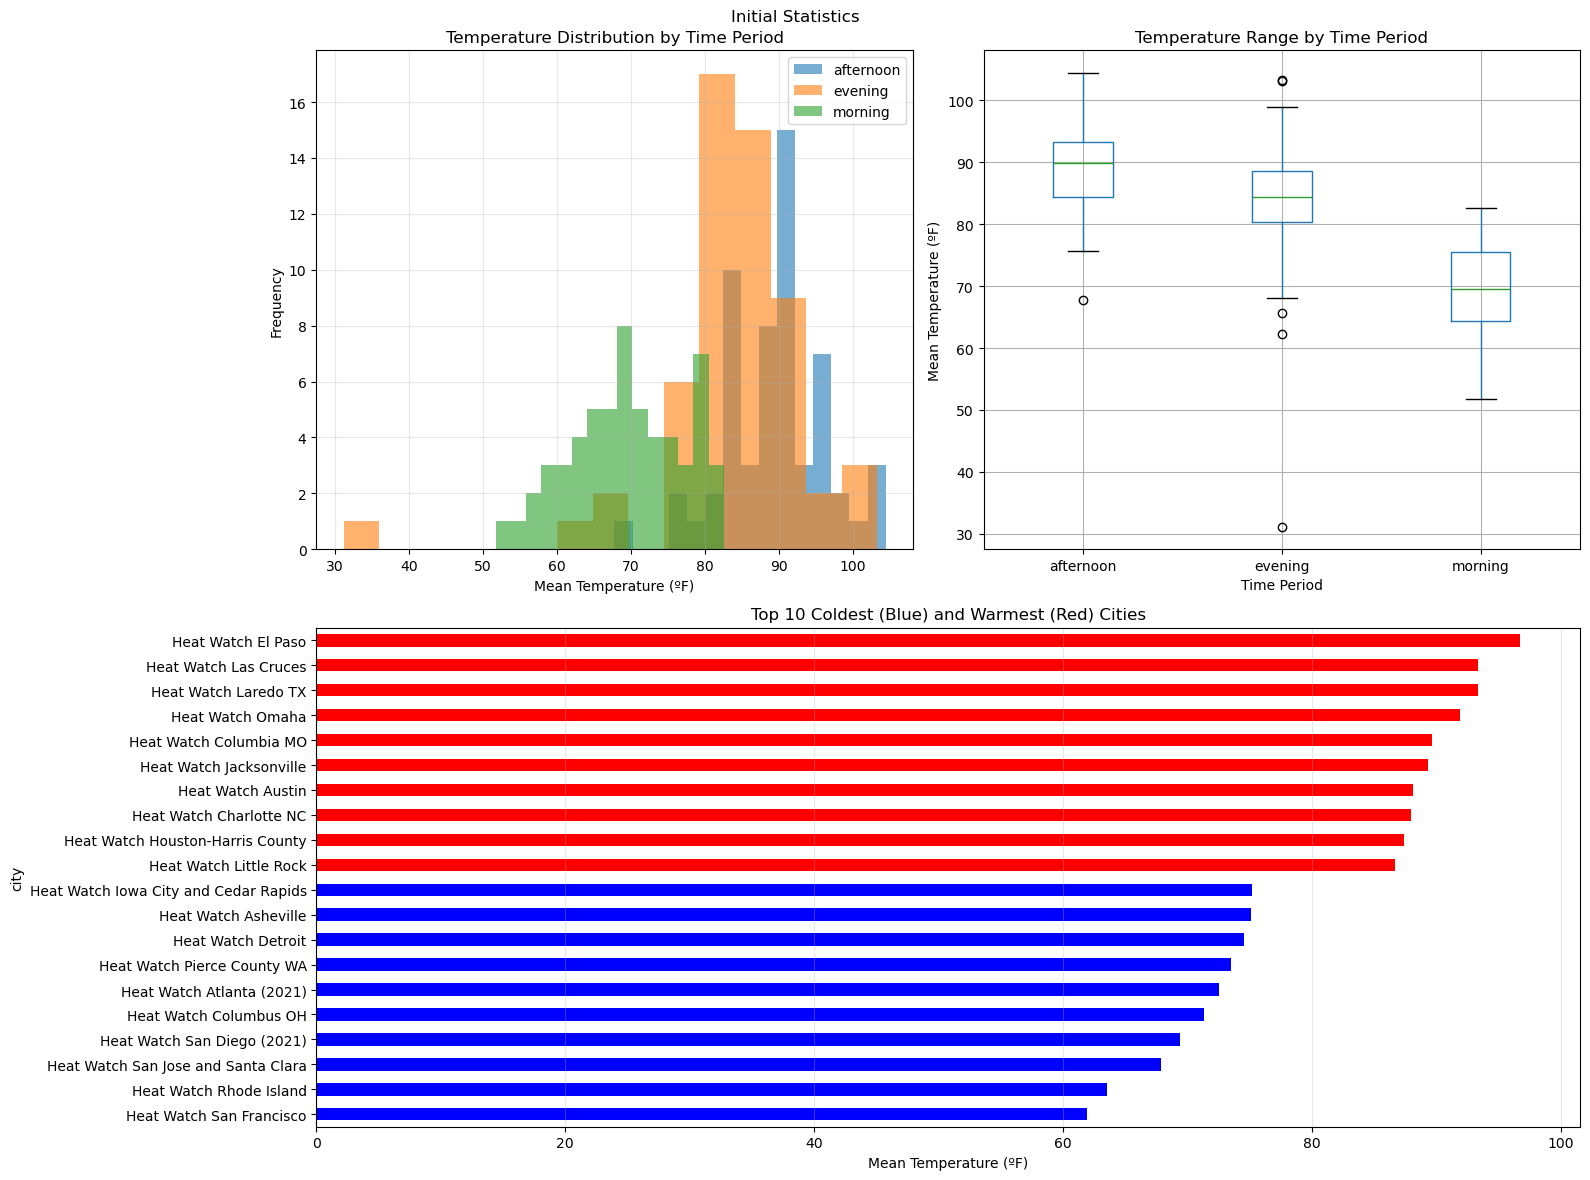

In [29]:
def create_visualizations(df):
    """Create comprehensive visualizations"""
    
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(2, 2, figure=fig) # rows, columns, figure
    axes = [fig.add_subplot(gs[0, 0]),
            fig.add_subplot(gs[0, 1]),
            fig.add_subplot(gs[1, :]),
        ]
    
    # 1. Temperature distribution by time period
    ax = axes[0]
    time_periods = df['time_period'].unique()
    for period in sorted(time_periods):
        period_data = df[df['time_period'] == period]['mean_temp']
        ax.hist(period_data, alpha=0.6, label=period, bins=15)
    ax.set_xlabel('Mean Temperature (ºF)')
    ax.set_ylabel('Frequency')
    ax.set_title('Temperature Distribution by Time Period')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Box plot by time period
    ax = axes[1]
    df.boxplot(column='mean_temp', by='time_period', ax=ax)
    ax.set_xlabel('Time Period')
    ax.set_ylabel('Mean Temperature (ºF)')
    ax.set_title('Temperature Range by Time Period')
    # plt.sca(ax)
    # plt.xticks(rotation=45)
    
    # 3. Top and bottom cities
    ax = axes[2]
    city_temps = df.groupby('city')['mean_temp'].mean().sort_values()
    top_bottom = pd.concat([city_temps.head(10), city_temps.tail(10)])
    top_bottom.plot(kind='barh', ax=ax, color=['red' if x in city_temps.tail(10).index else 'blue' for x in top_bottom.index])
    ax.set_xlabel('Mean Temperature (ºF)')
    ax.set_title('Top 10 Coldest (Blue) and Warmest (Red) Cities')
    ax.grid(True, alpha=0.3, axis='x')

    plt.suptitle('Initial Statistics')
    plt.tight_layout()
    plt.show()

create_visualizations(df)